# チュートリアル3: ブロックの配置の決定方法を理解しよう

## このノードブックの目的
- AIモデルの推論からブロックの配置の決定までの流れを理解する。

### チュートリアル 1,2と同じくブロックを可視化する関数とサンプル用テストデータを定義しましょう.

## 0.1. matplotlibのインストール 
可視化用のライブラリ[matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)をインストールします。

In [2]:
!pip install matplotlib

You should consider upgrading via the '/Users/ishibushisatoshi/tetris/.venv/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## 0.2. サンプル用テストデータの準備
- AIモデルに入力するサンプル用テストデータをロードします。
- チュートリアルとして10パターンのテストデータを格納した .npz ファイルを用意しています。

In [5]:
import numpy as np
tutorial_data = np.load("./test_data10.npz") #1~10までのサンプル用状態データをロード

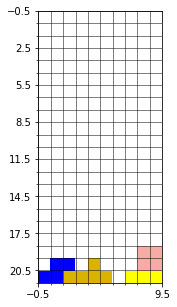

In [6]:
colors = [[255,255,255],
          [255,0,0],
          [0,255,0],
          [255,255,0], 
          [218, 179, 0],
          [247, 171, 166],
          [0,0,255],
          [255,255,0]]

#ブロック可視化関数 (numpy 配列からテトリスの盤面を可視化)
def visualize_block(data, shape, size=0.5):
    block_array = []
    fig, ax = plt.subplots()
    fig.set_figwidth(shape[0] * size)
    fig.set_figheight(shape[1] * size)
    for i in range(shape[0]):
        row = []
        for j in range(shape[1]):
            c = colors[int(data[i][j])]
            row.append(c)
        block_array.append(row)
    block_array = np.array(block_array)
    im = plt.imshow(block_array)

    #グリッド線を引く
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 23, 1.0), minor=True)
    ax.set_xticks(np.arange(-0.5, 10,10))
    ax.set_yticks(np.arange(-0.5, 23, 3))
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    ax.imshow(block_array)
    
shape = tutorial_data["1"].shape 
visualize_block(tutorial_data["1"],shape) #サンプル用状態データ１を可視化

# 3章 次の状態の価値を推論させてみよう!
- サンプル用のコードでは現在の状態（盤面）と次のブロックから次の状態を取得し、それらの次の状態をAIモデルに入力する- 
- そして、AIモデルの推論結果で最も価値が高いものを次の状態として採用し、そのブロックの置き方（行動）を取る。
- 本章では次の状態の取得から、次の行動を取得するまでの流れを示す。

In [7]:

def getShapeCoordArray(Shape_class, direction, x, y):
    coordArray = Shape_class.getCoords(direction, x, y) # get array from shape direction, x, y.
    return coordArray


# ブロックを配置
def dropDown(self, board, Shape_class, direction, x):
    dy = board_data_height - 1
    coordArray = self.getShapeCoordArray(Shape_class, direction, x, 0)
    # update dy
    for _x, _y in coordArray:
        _yy = 0
        while _yy + _y < board_data_height and (_yy + _y < 0 or board[(_y + _yy) * board_data_width + _x] == ShapeNone_index):
            _yy += 1
        _yy -= 1
        if _yy < dy:
            dy = _yy
    _board = dropDownWithDy(board, Shape_class, direction, x, dy)
    return _board


# ブロックを配置後の盤面を取得
def getBoard(board_backboard, Shape_class, direction, x):
    board = copy.deepcopy(board_backboard)
    _board = dropDown(board, Shape_class, direction, x)
    return _board

def get_next_states_v2(curr_backboard,piece_id,CurrentShape_class):
    states = {}
    if piece_id == 5: 
        num_rotations = 1
    elif piece_id == 1 or piece_id == 6 or piece_id == 7:
        num_rotations = 2
    else:
        num_rotations = 4
        
    for direction0 in range(num_rotations):
        x0Min, x0Max = self.getSearchXRange(CurrentShape_class, direction0)
        for x0 in range(x0Min, x0Max):
            board = getBoard(curr_backboard, CurrentShape_class, direction0, x0)
            reshape_backboard = get_reshape_backboard(board)
            reshape_backboard = torch.from_numpy(reshape_backboard[np.newaxis, :, :]).float()
            states[(x0, direction0)] = reshape_backboard
    return states

In [ ]:
# ###index を1~10の番号に変えてみてください###

data_index =  1 

# #######################################
tutorial_data = np.load("tutorial_data/test_data10.npz") #1~10までのサンプル用状態データをロード
load_data = tutorial_data[repr(data_index)] 
shape = load_data.shape
visualize_block(load_data ,shape) #データを可視化,curr_piece_id,curr_shape_class)
curr_backboard = load_data.flatten()

In [ ]:
import sys
sys.path.append("../../../")
from board_manager import Shape
from board_manager import BOARD_DATA

BOARD_DATA.clear()
BOARD_DATA.createNewPiece()